In [ ]:
!pip install tensorflow opencv-python matplotlib


In [ ]:
#Import standard dependcies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
#Import tensorflow dependcies
from tensorflow.keras.models import Model
#layer allows us build a custom layer
#Conv2D allows us to make convulional neural networks
#MaxPooling reduces the amount of data we pass to the next layer
#Input allows us to pass through to our model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
#Sets up folder path's
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
#MAKES DIRECTORIES
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
#Uncompressed the labeled faces in the wild data set
#This file is used to validate against our face (aka our "negative images")
!tar -xf lfw.tgz

In [ ]:
#adds all files to the negative directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
#This librarys allows us to generate uniqe images names
import uuid

In [ ]:
#Creates a connection to the webcam
cap = cv2.VideoCapture(0)
#loops through every frame
while cap.isOpened():
    #captures the frame
    ret, frame = cap.read()
    #sets the frame to be 250 by 250
    frame = frame[120:120+250,200:200+250, :]
    
    #Collects anchor images when a is pressed
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Creates a uniqe image name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #saves the frame to the directory
        cv2.imwrite(imgname, frame)
    #Collects a positive image
    if cv2.waitKey(1) & 0xFF == ord('p'):
         #Creates a uniqe image name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #saves the frame to the directory
        cv2.imwrite(imgname, frame)
    
    #shows the image onto the screen
    cv2.imshow('Image Collection', frame)
    #Stops the function
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#For some reason in Mac, this doesn't work
#will look more deeply into it later
cv2.destroyWindow('Image Collection')

#releases the webcam
cap.release()

In [ ]:
#takes 300 images of each type of image collected into an tf dataset
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [ ]:
#prepoccess the images
def preprocess(file_path):
    #Read the image from file path
    byte_img = tf.io.read_file(file_path)
    #loads the iamge
    img = tf.io.decode_jpeg(byte_img)
    #resizes
    img = tf.image.resize(img,(100,100))
    #re-scales
    img = img / 255.0
    return img

In [ ]:
#creates labeled positives(represented by 1)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#Creates labeled negatives(represented by 0)
negaitves = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negaitves)

In [ ]:
#returned loaded and preprocessed image
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Builds the data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#ensures images are mixed instead of all positives
#followed by all negatives
data = data.shuffle(buffer_size=1024)

In [ ]:
data

In [ ]:
#Training parition of data
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
#prefecteches images do we don't overload our neural network
train_data = train_data.prefetch(8)

In [ ]:
train_data

In [ ]:
#Testing parition of data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding():
    #input layer
    inp = Input(shape=(100,100,3), name='input_image')
    #first convulational layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    #first pooling layer
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    
    #second convulational layer
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    #second pooling layer
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    #Third convulational layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    #thid pooling layer
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    #fourth convulational layer
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    #taking the three dimesions and flattening it into one dimension
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1],name= 'embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
#uses the two neural network streams
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    #Uses anchor image and positive/negative
    #to compare their similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [ ]:
def make_siamese_model():
    
    #anchor inmage input in one network stream
    input_image = Input(name = 'input_img', shape=(100,100,3))
    
    #validation image in the other network stream
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    
    #combine the siamese distance layer/streams
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #outputs either a one or zero
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')
    
    

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

In [ ]:
#loss fucntion uses binary entropy
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
#sets optimizer with learning rate of .0004
#Adam was chosen because it provides good
#effeciecney with a lot of paramaters
opt = tf.keras.optimizers.legacy.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
#formats our checkpoints with ckpt
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
#saves the optimizer and and the model
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [ ]:
#tf function decorator compiles our step function
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        
        #Get anchor and positive/negative image
        #splices the batch into anchor and either positive
        #or negative
        X = batch[:2]
        #Get Label
        y = batch[2]
        
        #predicted outcome
        yhat = siamese_model(X, training = True)
        
        #cacluates the loss
        loss = binary_cross_loss(y, yhat)
        
    #calcuates the gradients
    #calcuates all of our gradients with to our loss
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calcuate updated witghts and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss
    
    
        

In [ ]:
def train(data, EPOCHS):
    #Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        #loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 30

In [ ]:
train(train_data, EPOCHS)

In [ ]:
#import metric calcuations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
#Retrieving our test data
#test input, represents webcam feed
#test val is our validation data
#y_true is our labeled value
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
#Prediction on our model
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
#Post processing results
#converts labeled output into a 1 or zero if it achevies a 
#certain threshold
[1 if prediction > .5 else 0 for prediction in y_hat]

In [ ]:
y_true

In [ ]:
#this model looks really good!

In [ ]:
#creates a metric object
m = Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return recall result
m.result().numpy()

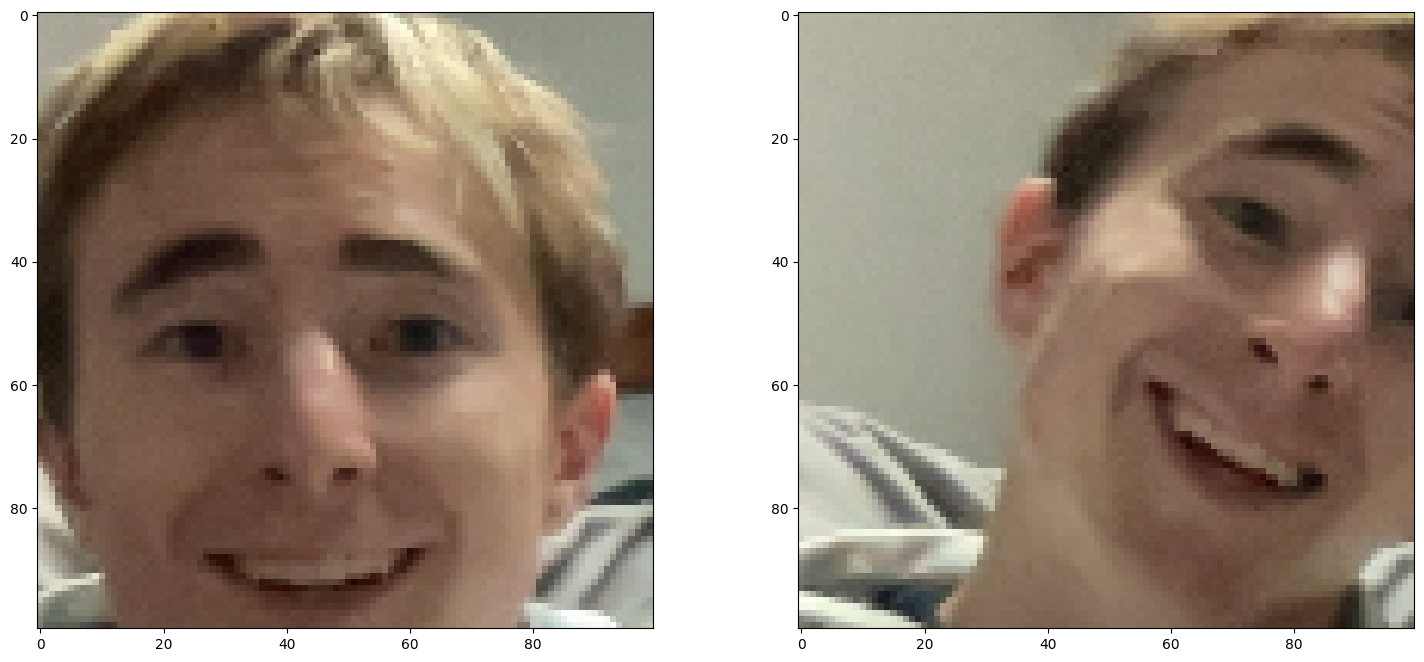

In [46]:
#Visualizing results
#We take our 1's and 0's and see
#if the images match!
plt.figure(figsize = (18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[5])
plt.subplot(1,2,2)
plt.imshow(test_val[5])
plt.show()

In [ ]:
#Save the siamese model weights
siamese_model.save('siamesemodel.h5')

In [ ]:
#Reload the model
model = tf.keras.models.load_model('siamesemodel.h5',
                            custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [45]:
model.predict([test_input, test_val])

1/1 [==============================] - 1s 824ms/step


array([[1.0000000e+00],
       [2.3456329e-07],
       [6.2828491e-08],
       [1.0000000e+00],
       [3.7396566e-09],
       [9.9999863e-01],
       [1.0000000e+00],
       [1.7658166e-07],
       [7.7889359e-07],
       [2.3639323e-08],
       [4.3044665e-06],
       [9.9998671e-01],
       [3.7369330e-09],
       [4.3740198e-09],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [60]:

#model is our siamese neural network
#detection threshold is the threshold where our predictions is positive
#verifcation_threshold is the threshold is the proportion of positive predictions to positive samples
def verify(model, detection_threshold, verifcation_threshold):
    results = []
    #takes images from our folder
    for image in os.listdir(os.path.join('application_data', 'verifcation_images')):
        #grabs input image from webcam
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verifcation_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis =1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verifcation_images')))
    verified = verification > verifcation_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification', frame)
    
    #begin verfication process
    if cv2.waitKey(10) & 0XFF  == ord('v'):
        #Save's image to image folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        
        results, verified = verify(model,.9,.7)
        print(verified)
    
    if cv2.waitKey(10) & 0XFF  == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()